In [136]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [137]:
# functions
def empirical_response(empirical_resp, stim_vals, x, stretch=1):
    stim_vals = stim_vals*stretch
    X = []
    for val in x:
        X.append(np.argmin(np.abs(stim_vals-val)))
    return empirical_resp[X]

def make_noise(exp_stim_resp, num_stim_vals, exp_stim_trials, scale=0.1):
    exp_stim_resp_noise = np.random.normal(scale=scale, size=(num_stim_vals, exp_stim_trials))
    noise_mask = np.expand_dims(np.abs(np.abs(exp_stim_resp-0.5)-0.5), axis=1)
    return np.multiply(exp_stim_resp_noise, np.repeat(noise_mask, exp_stim_trials, axis=1))

def compute_entropy(probs):
    return -probs @ np.log2(probs)

def compute_neuron_info(empirical_resp, stim_vals, exp_stim_vals, stretch=1, empirical=True):
    exp_stim_resp = empirical_response(empirical_resp, stim_vals, exp_stim_vals, stretch)
    if empirical:
        counts, edges = np.histogram(exp_stim_resp, bins=100)
        prob_stim_resp = counts/np.sum(counts)
        val_stim_resp = (edges[:-1]+edges[1:])/2
    else:
        prob_stim_resp = np.diff(np.hstack((np.array(0), exp_stim_resp)))
    # to remove P = 0
    nonzero_idx = prob_stim_resp>0
    return compute_entropy(prob_stim_resp[nonzero_idx]), prob_stim_resp, val_stim_resp

# Functionality: Maximizing Information Transmission

## Unimodal stimulus distribution

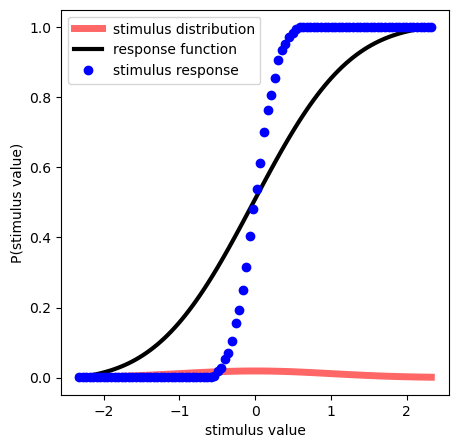

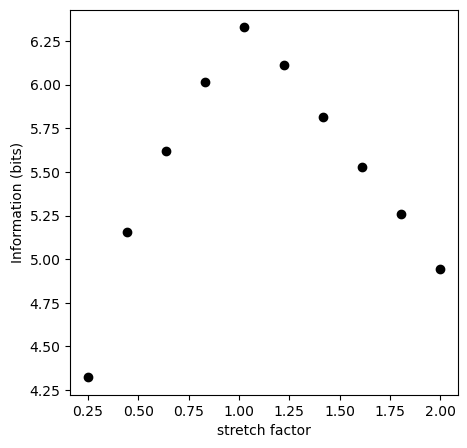

In [138]:
num_stim_vals = 100
stim_vals = np.linspace(sp.stats.norm.ppf(0.01), sp.stats.norm.ppf(0.99), num_stim_vals)
stim_uni_dist = sp.stats.norm.pdf(stim_vals)/np.sum(sp.stats.norm.pdf(stim_vals))
empirical_resp = np.cumsum(stim_uni_dist)
exp_stim_trials = 1000
exp_stim_vals = stim_vals
exp_stim_resp = empirical_response(empirical_resp, stim_vals, exp_stim_vals, stretch=0.25)
exp_stim_resp_noise = make_noise(exp_stim_resp, num_stim_vals, exp_stim_trials)

plt.figure(figsize=(5, 5))
plt.plot(stim_vals, stim_uni_dist, 'r-', lw=5, alpha=0.6, label='stimulus distribution')
plt.plot(stim_vals, empirical_resp, 'k-', lw=3, label='response function')
plt.plot(exp_stim_vals, exp_stim_resp, 'bo', lw=3, label='stimulus response')
plt.xlabel("stimulus value")
plt.ylabel("P(stimulus value)")
plt.legend()
plt.show()

# Show the information as a function of the stretch factor
stretch_factors = np.linspace(1/4, 2, 10)
entropies = np.zeros((len(stretch_factors),))

for i, stretch in enumerate(stretch_factors):
    exp_stim_resp = empirical_response(empirical_resp, stim_vals, exp_stim_vals, stretch=stretch)
    prob_stim_resp = np.diff(np.hstack((np.array(0), exp_stim_resp)))
    # to remove P = 0
    nonzero_idx = prob_stim_resp>0
    entropies[i] = compute_entropy(prob_stim_resp[nonzero_idx])

plt.figure(figsize=(5,5))
plt.plot(stretch_factors, entropies, 'ko', lw=3)
plt.xlabel("stretch factor")
plt.ylabel("Information (bits)")
plt.show()

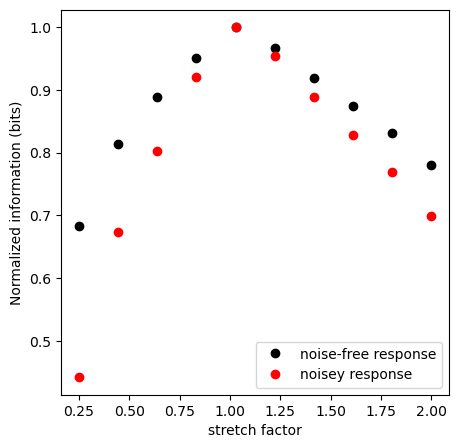

In [139]:
num_stim_vals = 100
stim_vals = np.linspace(sp.stats.norm.ppf(0.01), sp.stats.norm.ppf(0.99), num_stim_vals)
stim_uni_dist = sp.stats.norm.pdf(stim_vals)/np.sum(sp.stats.norm.pdf(stim_vals))
empirical_resp = np.cumsum(stim_uni_dist)

# Show the information as a function of the stretch factor
stretch_factors = np.linspace(1/4, 2, 10)
entropies_noise = np.zeros((len(stretch_factors),))

for istretch, stretch in enumerate(stretch_factors):
    # compute the information with the noise distribution conditional on the mean response
    exp_stim_resp = empirical_response(empirical_resp, stim_vals, exp_stim_vals, stretch=stretch)
    exp_noise = make_noise(exp_stim_resp, num_stim_vals, exp_stim_trials)
    # compute the probabilities
    prob_stim_resp = np.diff(np.hstack((np.array(0), exp_stim_resp)))
    # compute the entropy
    noise_term = 0
    for i in range(num_stim_vals):
        counts, _ = np.histogram(exp_noise[i,:])
        prob_noise = counts/np.sum(counts)
        nonzero_idx = prob_noise>0
        noise_term += prob_stim_resp[i]*compute_entropy(prob_noise[nonzero_idx])
    # to remove P = 0
    nonzero_idx = prob_stim_resp>0
    entropies_noise[istretch] = compute_entropy(prob_stim_resp[nonzero_idx]) - noise_term

plt.figure(figsize=(5,5))
plt.plot(stretch_factors, entropies/np.max(entropies), 'ko', lw=3, label='noise-free response')
plt.plot(stretch_factors, entropies_noise/np.max(entropies_noise), 'ro', lw=3, label='noisey response')
plt.xlabel("stretch factor")
plt.ylabel("Normalized information (bits)")
plt.legend()
plt.show()

## Bimodal stimulus distribution

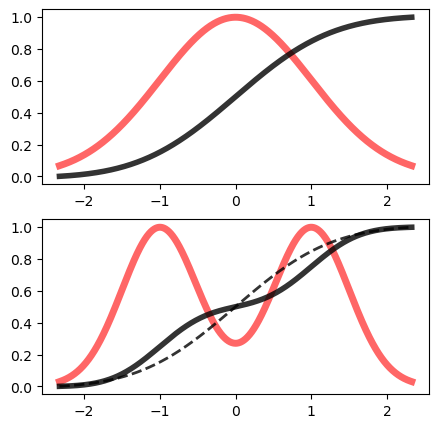

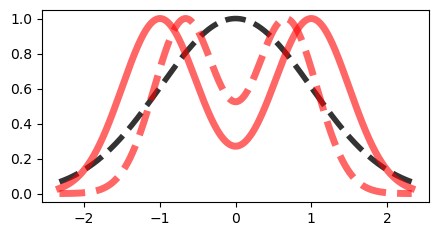

In [140]:
# create uni- and bimodal stimulus distributions
num_stim_vals = 1000
stim_vals = np.linspace(sp.stats.norm.ppf(0.01), sp.stats.norm.ppf(0.99), num_stim_vals)
stim_uni_dist = sp.stats.norm.pdf(stim_vals)/np.sum(sp.stats.norm.pdf(stim_vals))
stim_bi_dist  = sp.stats.norm.pdf(stim_vals, loc=-1, scale=0.5) + sp.stats.norm.pdf(stim_vals, loc=1, scale=0.5)
stim_bi_dist  = stim_bi_dist/np.sum(stim_bi_dist)
scale_factor = 1/1.5
stim_bi_dist_compress = sp.stats.norm.pdf(stim_vals, loc=-1*scale_factor, scale=np.sqrt(scale_factor)*0.5) +\
    sp.stats.norm.pdf(stim_vals, loc=1*scale_factor, scale=np.sqrt(scale_factor)*0.5)
stim_bi_dist_compress = stim_bi_dist_compress/np.sum(stim_bi_dist_compress)
empirical_resp_uni = np.cumsum(stim_uni_dist)
empirical_resp_bi = np.cumsum(stim_bi_dist)

fig, ax = plt.subplots(2, 1, figsize=(5,5))
# unimodal stimulus distribution
ax[0].plot(stim_vals, stim_uni_dist/np.max(stim_uni_dist), color='r', lw=5, alpha=0.6)
ax[0].plot(stim_vals, empirical_resp_uni, color='k', lw=4, alpha=0.8)
# bimodal stimulus distribution
ax[1].plot(stim_vals, stim_bi_dist/np.max(stim_bi_dist), color='r', lw=5, alpha=0.6)
ax[1].plot(stim_vals, empirical_resp_bi, color='k', lw=4, alpha=0.8)
ax[1].plot(stim_vals, empirical_resp_uni, color='k', linestyle='--', lw=2, alpha=0.8)
plt.show()

plt.figure(figsize=(5,2.5))
plt.plot(stim_vals, stim_uni_dist/np.max(stim_uni_dist), color='k', linestyle='--', lw=4, alpha=0.8)
plt.plot(stim_vals, stim_bi_dist/np.max(stim_bi_dist), color='r', lw=5, alpha=0.6)
plt.plot(stim_vals, stim_bi_dist_compress/np.max(stim_bi_dist_compress), color='r', linestyle='--', lw=5, alpha=0.6)
plt.show()

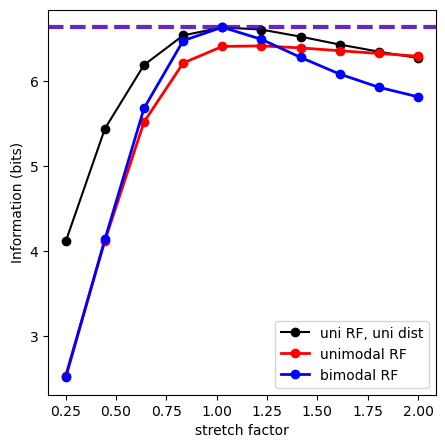

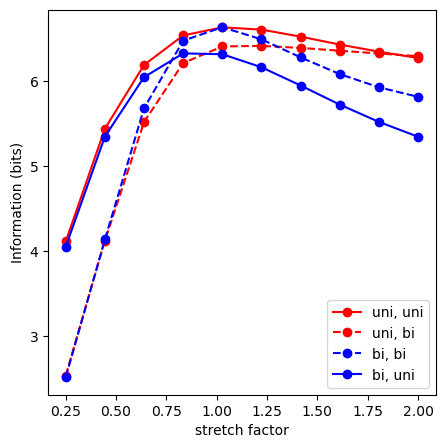

In [141]:
# Compute the entropies
num_dist_vals = 1000
num_stim_vals = 10000
exp_stim_vals = [np.random.normal(size=(num_stim_vals,)),
                 np.concatenate((np.random.normal(loc=-1, scale=0.5, size=(int(num_stim_vals/2),)),
                                 np.random.normal(loc=1,  scale=0.5, size=(int(num_stim_vals/2),))))]
dists = [stim_uni_dist, stim_bi_dist]
empirical_resps = [empirical_resp_uni, empirical_resp_bi]
stretch_factors = np.linspace(1/4, 2, 10)
entropies = np.zeros((2, 2, len(stretch_factors))) # dim0: response function, dim1: stimulus distribution
noise_terms = np.zeros((2, 2, len(stretch_factors)))
calc_noise_term = False

for irf in range(2):
    for isd in range(2):
        for istretch, stretch in enumerate(stretch_factors):
            entropies[irf, isd, istretch], _, _ = compute_neuron_info(empirical_resps[irf], stim_vals,
                                                                   exp_stim_vals[isd], stretch=stretch)
            if calc_noise_term:
                # NOISE
                # compute the information of the noise distribution conditional on the mean response
                # compute the probabilities of the neuron response to the stimuli
                _, prob_stim_resp, val_stim_resp = compute_neuron_info(empirical_resps[irf], stim_vals,
                                                        exp_stim_vals[isd], stretch=stretch)
                # create the noise
                exp_noise = make_noise(val_stim_resp, len(val_stim_resp), num_stim_vals, 10.0)
                # compute the entropy
                noise_term = 0
                for i in range(len(prob_stim_resp)):
                    counts, _ = np.histogram(exp_noise[i,:])
                    prob_noise = counts/np.sum(counts)
                    nonzero_idx = prob_noise>0
                    noise_term += prob_stim_resp[i]*compute_entropy(prob_noise[nonzero_idx])
                # to remove P = 0
                nonzero_idx = prob_stim_resp>0
                noise_terms[irf, isd, istretch] = noise_term

plt.figure(figsize=(5,5))
plt.plot(stretch_factors, entropies[0,0,:], marker='o', color='k', label='uni RF, uni dist')
plt.axhline(entropies[0,0,4], color='r', linestyle='--', lw=3, alpha=0.6)
plt.plot(stretch_factors, entropies[0,1,:], marker='o', color='r', lw=2, label='unimodal RF')
plt.plot(stretch_factors, entropies[1,1,:], marker='o', color='b', lw=2, label='bimodal RF')
plt.axhline(entropies[1,1,4], color='b', linestyle='--', lw=3, alpha=0.6)
plt.xlabel('stretch factor')
plt.ylabel('Information (bits)')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(5,5))
plt.plot(stretch_factors, entropies[0,0,:]-noise_terms[0,0,:], marker='o', color='r', label='uni, uni')
plt.plot(stretch_factors, entropies[0,1,:]-noise_terms[0,1,:], marker='o', color='r', linestyle='--', label='uni, bi')
plt.plot(stretch_factors, entropies[1,1,:]-noise_terms[1,1,:], marker='o', color='b', linestyle='--', label='bi, bi')
plt.plot(stretch_factors, entropies[1,0,:]-noise_terms[1,0,:], marker='o', color='b', label='bi, uni')
plt.xlabel('stretch factor')
plt.ylabel('Information (bits)')
plt.legend(loc="lower right")
plt.show()


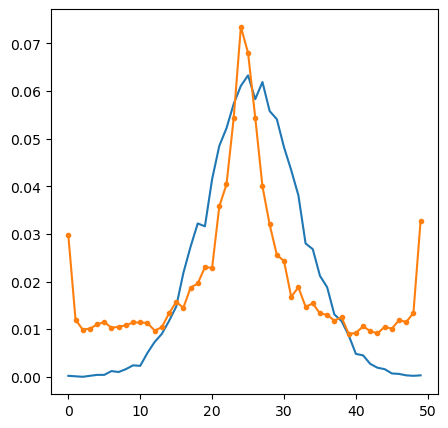

5.325790818018194

In [142]:
exp_stim_vals = np.random.normal(size=(10000,))
counts, _ = np.histogram(exp_stim_vals, bins=50)
prob_stim = counts/np.sum(counts)

exp_resp_vals = empirical_response(empirical_resp_bi, stim_vals, exp_stim_vals)
counts, _ = np.histogram(exp_resp_vals, bins=50)
prob_resp = counts/np.sum(counts)

plt.figure(figsize=(5,5))
plt.plot(prob_stim)
plt.plot(prob_resp, marker='.')
plt.show()

compute_entropy(prob_resp)